In [2]:
import pandas as pd
import spacy
import en_core_web_sm
import en_core_web_lg
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

In [3]:
#=== Getting only 30 reviews ===#
# df = pd.read_csv("./downloads/reviews100.csv")
# df['comment'] = df['comment'].apply(lambda x: x.strip())
# #df = df.sort_values(['stars'], ascending=False).iloc[0:30] # get 30 top reviews 
# df = df.sample(frac=1).iloc[0:30] # get 30 top reviews 
# df.to_csv("30_reviews.csv", index=False) # save to csv for manual review
# df

In [4]:
df = pd.read_csv("./30_reviews.csv")
df

,stars,comment
0,1.0 out of 5 stars,"So I decided I wanted to get a paper shredder,..."
1,1.0 out of 5 stars,I order a lot from Amazon for convenience but ...
2,5.0 out of 5 stars,Pretty thrilled with this shredder right now !...
3,1.0 out of 5 stars,I have now been through 3 of these shredders. ...
4,5.0 out of 5 stars,"Update: After over a year, the shredder is sti..."
5,1.0 out of 5 stars,"SAYS it's made for home office, I guess becau..."
6,5.0 out of 5 stars,Quiet machine with ample capacity both in numb...
7,1.0 out of 5 stars,Very disappointed. Received shredder and plugg...
8,5.0 out of 5 stars,The Shredder is listed as a light/medium duty ...
9,3.0 out of 5 stars,"Will only give it 3 stars, since it arrived br..."


In [5]:
#=== Manually selected pairs ===#
manual_pairs = ["wonderful shredder", "it doesn't work", "shredder is heavy", "Quiet machine", "shredder was good value"]
print('The manually selected pairs are:', manual_pairs)

The manually selected pairs are: ['wonderful shredder', "it doesn't work", 'shredder is heavy', 'Quiet machine', 'shredder was good value']


In [6]:
nlp = en_core_web_sm.load() # for ipynb
noun_adj_pairs = {}
for _, comment in enumerate(df['comment']):
    doc = nlp(comment) # change tuple to str for nlp
    for sent in doc.sents:
        for chunk in sent.noun_chunks:
            for possible_adjective in chunk.root.children:
                if possible_adjective.pos_ == 'ADJ':
                    if possible_adjective.text not in chunk.text:
                        pair = (chunk.text.lower(), possible_adjective.text.lower())
                    else:
                        pair = (chunk.root.text.lower(), possible_adjective.text.lower())
                    if pair not in noun_adj_pairs: 
                        noun_adj_pairs[pair] = 1
                    else:
                        noun_adj_pairs[pair] += 1
print(len(noun_adj_pairs))
top_5_noun_adj_pairs = dict(Counter(noun_adj_pairs).most_common(5))
top_5_noun_adj_pairs

205


{('letters', 'unopened'): 2,
 ('function', 'reverse'): 2,
 ('slot', 'intake'): 2,
 ('price', 'great'): 2,
 ('value', 'good'): 2}

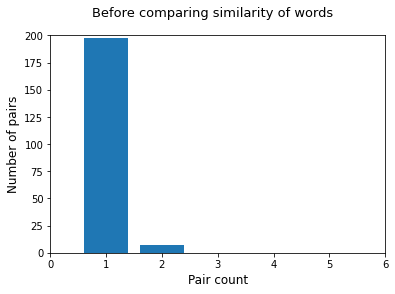

In [14]:
%matplotlib inline
pair_counts = {}
for val in noun_adj_pairs.values():
    if val in pair_counts.keys():
        pair_counts[val] += 1
    else:
        pair_counts[val] = 1
fig = plt.figure()
plt.bar(pair_counts.keys(), pair_counts.values())
plt.axis([0, 6, 0, 200]) #xmin, xmax, ymin, ymax
fig.suptitle('Before comparing similarity of words', fontsize=13)
plt.xlabel('Pair count', fontsize=12)
plt.ylabel('Number of pairs', fontsize=12)
# plt.show()
fig.savefig('before_similarity.jpg')

In [9]:
def find_val(val_to_find: tuple):
    for key, value in similar_pairs.items():
        for val in value:
            if val_to_find == val:
                return key
    return False
# This will take some time to run
nlp = en_core_web_lg.load() # for ipynb
similar_pairs = {}
key_index = 0
for index, pair in enumerate(noun_adj_pairs):
    for index2, pair2 in enumerate(noun_adj_pairs):
        if index2 <= index:
            continue
        # make a pair using adj + noun/noun phrase, 
        similarity = nlp(pair[1]+' '+pair[0]).similarity(nlp(pair2[1]+' '+pair2[0]))
        if similarity > 0.85:
            # print(pair, pair2)
            # check if pair/pair2 exists as values
            if find_val(pair) and not find_val(pair2):
                print('a1', pair, pair2)
                # check if pair2 exist as val
                similar_pairs[find_val(pair)].append(pair2)
            elif find_val(pair2) and not find_val(pair):
                print('a2', pair2, pair)
                similar_pairs[find_val(pair2)].append(pair)
            elif not find_val(pair) and not find_val(pair2):
                print('c', pair, pair2)
                similar_pairs[key_index] = [pair]
                similar_pairs[key_index].append(pair2)
                key_index += 1
            else:
                print('this shld not happen')
            print(similar_pairs)

cords', 'old'), ('documents', 'old'), ('paperwork', 'old'), ('documents', 'most'), ('documents', 'several')], 11: [('sheet', 'single'), ('sheet', 'first'), ('sheet', 'entire')], 12: [('shaking', 'little'), ('shaking', 'gentle')], 13: [('job', 'better'), ('job', 'first')], 14: [('special', 'old'), ('one', 'old')], 15: [('product', 'great'), ('quality', 'great')], 16: [('issue', 'big'), ('issue', 'only')], 17: [('years', 'several'), ('weeks', 'few'), ('people', 'several')], 18: [('pieces', 'several'), ('items', 'several')], 19: [('end', 'other'), ('ways', 'other')], 20: [('products', 'defective'), ('merchandise', 'defective')]}
a1 ('products', 'defective') ('products', 'faulty')
{0: [('letter', 'third'), ('letter', 'last')], 1: [('model', 'same'), ('model', 'stronger'), ('model', 'new'), ('model', 'right'), ('model', 'previous')], 2: [('bag', 'full'), ('bag', 'entire')], 3: [('shredder', 'old'), ('shredder', 'little'), ('shredder', 'slow')], 4: [('reason', 'same'), ('thing', 'first'), ('

In [16]:
new_noun_adj_pairs = noun_adj_pairs.copy()
for _, value in similar_pairs.items():
    for index, val in enumerate(value):
        if index == 0:
            root = val
            continue
        new_noun_adj_pairs[root] += new_noun_adj_pairs[val]
        del new_noun_adj_pairs[val]
new_top_5_noun_adj_pairs = dict(Counter(new_noun_adj_pairs).most_common(10))
new_top_5_noun_adj_pairs

{('reason', 'same'): 6,
 ('model', 'same'): 5,
 ('records', 'old'): 5,
 ('shredder', 'cut'): 4,
 ('price', 'economical'): 4,
 ('shredder', 'old'): 3,
 ('the price', 'heavy'): 3,
 ('sheet', 'single'): 3,
 ('years', 'several'): 3,
 ('pieces', 'several'): 3}

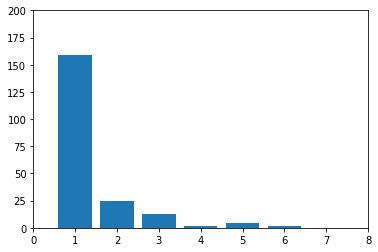

In [52]:
%matplotlib inline
new_pair_counts = {}
for val in new_noun_adj_pairs.values():
    if val in new_pair_counts.keys():
        new_pair_counts[val] += 1
    else:
        new_pair_counts[val] = 1
new_pair_counts
plt.bar(new_pair_counts.keys(), new_pair_counts.values())
plt.axis([0, 8, 0, 200]) #xmin, xmax, ymin, ymax
plt.show()